<a href="https://colab.research.google.com/github/realmistic/PythonInvest-basic-fin-analysis/blob/master/PythonInvest_com_5_Get_EU_ETFs_with_Selenium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Passive Investment with Exchange Traded Funds (ETFs) in Europe**
* **What?** Analyse >1000 ETF funds in Europe
* **Why?** A wide set of investment options and diversification
* **Tech skills with Python** Scraping web data with Selenium
* **How?**
  0. Imports and how to make Selenium work with Colab
  1. Get the list of ~1000 ISINs
  3. Scrape one detailed page with Selenium
  4. Expand the approach to get all the data from all pages available 


**Why Selenium?** The pagination problem for the Requests library (static HTTP requests): 
* https://www.justetf.com/en/find-etf.html?groupField=none&distributionPolicy=distributionPolicy-accumulating&sortField=fundSize&sortOrder=desc

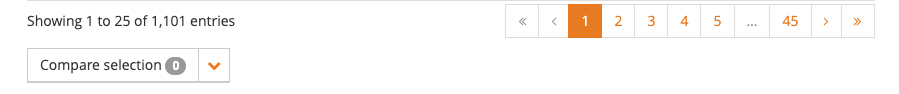

# 0) Imports

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 968 kB 14.6 MB/s 
     |████████████████████████████████| 359 kB 55.6 MB/s 
     |████████████████████████████████| 138 kB 55.6 MB/s 
     |████████████████████████████████| 3.6 MB 47.1 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu

In [ ]:
# How to make Selenium work in Colab
# https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd2 = webdriver.Chrome('chromedriver',chrome_options=chrome_options)


from selenium.webdriver.common.by import By
from regex.regex import match
import regex as re
import math

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: use options instead of chrome_options
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


In [ ]:
import pandas as pd
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# 1) Get the list of ~1000 EU ETFs (Accumulating)

In [ ]:
# We define MAX number of ISINs to download (manual check before scraping)
MAX_ISINS_COUNT = 1100
wd.get("https://www.justetf.com/en/find-etf.html?groupField=none&distributionPolicy=distributionPolicy-accumulating&sortField=fundSize&sortOrder=desc")

In [ ]:
# Get all href links with "isin" param
def get_links():
  elems = wd.find_elements_by_class_name("link")
  print(f'Found elems with links {elems}')

  rez = [] #array with links
  time.sleep(1)
  for elem in elems:
    link_addr = elem.get_attribute("href")
    if link_addr is not None and "&isin=" in link_addr:
      if rez is None:
        rez = [link_addr]
      else:
        rez.append(link_addr)
  e = wd.find_element_by_xpath("//*[contains(text(),' entries')]")
  print(e.text)
  return rez

In [ ]:
import re
import time
import pandas as pd

In [ ]:
page = 1

links_df = pd.DataFrame()

while True:
  link_isins = get_links()
  if link_isins is None or len(link_isins)<=1: #for some reason it gives just 1 link when all other links are finished
    break

  print(f'Page {page}, found {len(link_isins)}')
  for link in link_isins:
    value = {
        'isin': re.search('isin=(.+)',link).group(1),
        'http_link': link
    }
    links_df = links_df.append(value, ignore_index=True)
  # print(link, re.search('isin=(.+)',link).group(1))
  time.sleep(2) # sleep 2 sec

  page +=1

  clck = wd.find_element_by_css_selector('a#etfsTable_next.paginate_button.next') #where to click
  if (not clck.is_enabled) or len(links_df) > MAX_ISINS_COUNT:
    break
  # clck.click() is not working! => need to find a workaround
  # https://stackoverflow.com/questions/48665001/can-not-click-on-a-element-elementclickinterceptedexception-in-splinter-selen
  wd.execute_script("arguments[0].click();", clck)
  time.sleep(2) # sleep 2 sec


In [ ]:
links_df

In [ ]:
pd.set_option('display.max_colwidth', None)
links_df.head(10)

In [ ]:
links_df.to_csv("EU_ETFs_ISINs.csv")

# 1.1) Or.. Download the ETFs_ISINS

In [ ]:
import pandas as pd
links_df = pd.read_csv("EU_ETFs_ISINs_for_scraping.csv")

In [ ]:
links_df = links_df.drop_duplicates(subset='isin')

In [ ]:
# How many ISINs were found?
links_df.shape

(1058, 3)

# 2) Define scrapping function

In [ ]:
# function for extracting float/int number PERCENT from a string 
def get_percent_from_text(str_):
  match = re.search('([-]?\d+[\.]?[\d+]*)%',str_) 
  if match:
    return float(match.group(1))
  else:
    return float("nan")

In [ ]:
# Check options and what to output when wrong value
print(get_percent_from_text("-4.5%"))
print(get_percent_from_text("29.90%"))
print(get_percent_from_text("addasd%"))
print(get_percent_from_text("2%"))

print( math.isnan(get_percent_from_text("5%")) )
print( math.isnan(get_percent_from_text("5asdf%")) ) # this should return True

-4.5
29.9
nan
2.0
False
True


In [ ]:
def scrape_one_fund_profile(url, isin_param):
  # Init with empty dict
  fund_params = {}

  full_url = url+'?isin='+isin_param
  # Get url stats from WebDriver
  # wd2 = webdriver.Chrome('chromedriver', chrome_options=chrome_options)
  wd2.get(full_url)

  page_unavailable = wd2.find_elements(By.XPATH,"//*[contains(text(),'Page is currently unavailable')]/..")
  if page_unavailable:
    print('Page is currently unavailable')
    return None
    # print(page_unavailable[0].get_property("innerText").split('\n')[0])
  # PRE: WAIT UNTIL ELEMENT APPEARS
  # https://stackoverflow.com/questions/44119081/how-do-you-fix-the-element-not-interactable-exception
  try:  
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR,"span.h1"))
    )    
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH,"//*[contains(text(),'Investment strategy')]/following-sibling::p"))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR,"span.identfier"))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH,"//*[contains(text(),'Investment strategy')]/following-sibling::p"))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH,"//*[contains(text(),'Quote')]/following-sibling::div"))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH,"//*[contains(text(),'Investment strategy')]/.."))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH,"//*[contains(text(),'Fund size')]/.."))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH,"//*[contains(text(),'Total expense ratio')]/.."))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH,"//*[contains(text(),'Total expense ratio')]/../following-sibling::div"))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH, "//*[contains(text(),'YTD')]/../../.."))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH,"//*[contains(text(),'Total expense ratio')]/.."))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH, "//*[contains(text(),'1 month')]/../../.."))  
    )  
  finally:
    pass

  # 0) Find fund name 
    # <span class="h1">iShares Core S&amp;P 500 UCITS ETF (Acc)</span>  
  elem = wd2.find_element(By.CSS_SELECTOR,"span.h1")
  fund_params['name'] = elem.text

  # 1) Getting ISIN and Ticker name. Ticker name seems to be different depending from what country you open the website
    # <span class="identfier">
    #                 <span class="vallabel">ISIN</span>
    #                 <span class="val">IE00B5BMR087,</span>
    #                 <span class="vallabel">WKN</span>
    #                 <span class="val">A0YEDG</span>
    #                 </span>
  elems = wd2.find_element(By.CSS_SELECTOR,"span.identfier").find_elements(By.CSS_SELECTOR,"span.val")
  fund_params['isin'] = elems[0].text.rstrip(',')
  fund_params['ticker'] = elems[1].text

  # 2) Investment strategy description
  elem = wd2.find_element(By.XPATH,"//*[contains(text(),'Investment strategy')]/following-sibling::p")
  fund_params['description'] = elem.get_property("innerText")

  # 3) Getting current price (quote in EUR), exchange, date of quote, 52w min and max values
  quote = wd2.find_element(By.XPATH,"//*[contains(text(),'Quote')]/following-sibling::div")
  quote_stats = quote.get_property("innerText").split('\n')

  fund_params['currency_quote'], fund_params['last_quote'] = quote_stats[0].split(' ')
  fund_params['last_quote'] = float(fund_params['last_quote'].replace(',',''))
  fund_params['exchange'] = quote_stats[1]
  fund_params['date_last_quote'] = quote_stats[2]
  fund_params['52weeks_low'], fund_params['52weeks_high'] = [float(x.replace(',','')) for x in quote_stats[3].split('  ')]

  # 4) Getting LABELS (and links for 'Factsheet EN' and 'KIID DE')
  labels_links = wd2.find_element(By.XPATH,"//*[contains(text(),'Investment strategy')]/..").find_elements(By.TAG_NAME,'a')
  fund_params['labels'] = [t.get_property("innerText") for t in labels_links if 'label' in t.get_attribute('class')]

  # for elem in labels_links:
  #   print(f"CLASS = {elem.get_attribute('class')}, TEXT = {elem.get_property('innerText')}")
  # let's not store the links for now
  # for t in labels_links:
    # if t.get_attribute('class') == 'download-link':
      # fund_params[t.get_property("innerText").split()[0] + '_link'] = t.get_property('href')

  # 5) Fund size
  # by default don't have any value in the funds size
  fund_params['fund_size'] = ''
  fund_size = wd2.find_elements(By.XPATH,"//*[contains(text(),'Fund size')]/..")
  for f in fund_size:
    match = re.search('(\d+[\,]?[\d]+)', f.get_property("innerText"))
    if not match:
      match = re.search('(\d+)',f.get_property("innerText")) #searching for just one number without ",""
    if match:
      fund_params['fund_size'] = int(match.group(1).replace(',',''))
  # str_fund_size = fund_size[0].get_property("innerText").split('\n')

  # 6) Total Expense Ratio (TER)
  ter = wd2.find_elements(By.XPATH,"//*[contains(text(),'Total expense ratio')]/..")
  fund_params['ter'] = ''
  for f in ter:
    ter_value = get_percent_from_text(f.get_property("innerText"))
    if not math.isnan(ter_value):
      fund_params['ter'] = ter_value

  # 7) Get min-max TER and COMPARABLE Category name
  #  example: ['0.04%  1.38%', 'Compare ( Equity )']
  compare_ter = ter[0].find_element(By.XPATH,"//*[contains(text(),'Total expense ratio')]/../following-sibling::div")
  elems = compare_ter.get_property("innerText").split('\n')
  fund_params['ter_compare_min'] = get_percent_from_text(elems[0].split('  ')[0])
  fund_params['ter_compare_max'] = get_percent_from_text(elems[0].split('  ')[1])
  fund_params['ter_compare'] = elems[1]
  

  # 8) get all table values params : normally there are more tables than we need
   #  example 1 (replication part): ['Replication', 'Physical (Full replication)', 'Legal structure', 'ETF', 'Strategy risk', 'Long-only', 'Fund currency', 'USD', 'Currency risk', 'Currency unhedged', 'Volatility 1 year (in EUR)', '14.28% ', 'Inception/ Listing Date', '19 May 2010']
   #  example 2 (domecile part): ['Distribution policy', 'Accumulating', 'Distribution frequency', '-', 'Fund domicile', 'Ireland', 'Tax data', 'Bundesanzeiger']

  tbody = wd2.find_elements(By.CSS_SELECTOR,"div.table-responsive table.table")
  for i in tbody:
    values = []
    text = i.get_property("innerText")
    if 'replication' in text.lower():
      op = i.find_elements(By.TAG_NAME,'td')
      values = [e.get_property('innerText') for e in op]
    if 'domicile' in text.lower():
      op = i.find_elements(By.TAG_NAME,'td')
      values = [e.get_property('innerText') for e in op]
    
    if values:
      # print(values)
      for i in range(0, len(values), 2):
        cur_value = get_percent_from_text(values[i+1])
        if not math.isnan(cur_value):
          fund_params[values[i]] = float(cur_value)
        else:
          fund_params[values[i]] = values[i+1]

  # 9) Other return values: one table with columns 'YTD' and '2021'
        # finding elem by text <th> YTD </th> 
        # --> Assuming hierarchy <table>/<thead>/<tr>/<th> => 
        # IMPORTANT: NEED TO WAIT UNTIL these elements load
  try:
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH, "//*[contains(text(),'YTD')]/../../.."))
    )
    element = WebDriverWait(wd2, 10).until(
        EC.presence_of_element_located((By.XPATH, "//*[contains(text(),'1 month')]/../../.."))    
    )
  finally:
    pass

  table1 = wd2.find_element(By.XPATH,"//*[contains(text(),'YTD')]/../../..")
  table2 = wd2.find_element(By.XPATH,"//*[contains(text(),'1 month')]/../../..")
  for table in [table1,table2]:  
    # all text in the table
    # example: "1 month\t3 months\t6 months\t1 year\t3 years\n-33.97%\t-47.91%\t-43.48%\t-27.58%\t-""
    text = table.get_property("innerText")  
    periods = text.split('\n')[0].split('\t')
    values = text.split('\n')[1].split('\t')
    values_float = [get_percent_from_text(val) for val in text.split('\n')[1].split('\t')]
    for i,period in enumerate(periods):
      fund_params['return_'+period.replace(' ','_')] = values_float[i]

  return fund_params   

In [ ]:
one_fund_scraped = scrape_one_fund_profile(url='https://www.justetf.com/en/etf-profile.html',
                                           isin_param='IE00B5BMR087')
one_fund_scraped

{'52weeks_high': 433.85,
 '52weeks_low': 339.79,
 'Currency risk': 'Currency unhedged',
 'Distribution frequency': '-',
 'Distribution policy': 'Accumulating',
 'Fund currency': 'USD',
 'Fund domicile': 'Ireland',
 'Inception/ Listing Date': '19 May 2010',
 'Legal structure': 'ETF',
 'Replication': 'Physical (Full replication)',
 'Strategy risk': 'Long-only',
 'Tax data': 'Bundesanzeiger',
 'Volatility 1 year (in EUR)': 15.43,
 'currency_quote': 'EUR',
 'date_last_quote': '08.04.22',
 'description': 'The S&P 500® index tracks the 500 largest US stocks.',
 'exchange': 'XETRA',
 'fund_size': 53508,
 'isin': 'IE00B5BMR087',
 'labels': ['S&P 500® (19)', 'Equity (1218)', 'United States (219)'],
 'last_quote': 424.62,
 'name': 'iShares Core S&P 500 UCITS ETF (Acc)',
 'return_1_month': 6.21,
 'return_1_year': 20.53,
 'return_2018': -0.2,
 'return_2019': 33.54,
 'return_2020': 8.04,
 'return_2021': 39.07,
 'return_3_months': -0.89,
 'return_3_years': 65.65,
 'return_6_months': 8.11,
 'return_Y

# 3) Scraping all funds by ISIN

In [ ]:
# check ISINs
links_df.head()

,Unnamed: 0,isin,http_link
0,0,IE00B5BMR087,https://www.justetf.com/en/etf-profile.html?gr...
1,1,IE00B4L5Y983,https://www.justetf.com/en/etf-profile.html?gr...
2,2,IE00BKM4GZ66,https://www.justetf.com/en/etf-profile.html?gr...
3,3,IE00B579F325,https://www.justetf.com/en/etf-profile.html?gr...
4,4,DE000A0S9GB0,https://www.justetf.com/en/etf-profile.html?gr...


In [ ]:
df_etf_funds = None

total_funds = len(links_df['isin']) 

for i,fund_isin in enumerate(links_df['isin']):
  if fund_isin in ('LU1563454823'):  #page is unavailable
    continue
  url = 'https://www.justetf.com/en/etf-profile.html'
  full_url = url+'?isin='+fund_isin
  print(f'Scraping fund {i}/{total_funds}, isin={fund_isin}, url ={full_url}')
  
  time.sleep(0.1) # sleep 0.1 sec
  one_fund_scraped = scrape_one_fund_profile('https://www.justetf.com/en/etf-profile.html', fund_isin)

  if df_etf_funds is None: # create a new dataFrame when first time
    df_etf_funds = pd.DataFrame(columns = list(one_fund_scraped.keys()))

  if one_fund_scraped is None:
    continue #there was a problem with scraping, like 'Page not found'

  df_etf_funds = df_etf_funds.append(one_fund_scraped, ignore_index=True)

Scraping fund 0/1058, isin=IE00B5BMR087, url =https://www.justetf.com/en/etf-profile.html?isin=IE00B5BMR087
Scraping fund 1/1058, isin=IE00B4L5Y983, url =https://www.justetf.com/en/etf-profile.html?isin=IE00B4L5Y983
Scraping fund 2/1058, isin=IE00BKM4GZ66, url =https://www.justetf.com/en/etf-profile.html?isin=IE00BKM4GZ66
Scraping fund 3/1058, isin=IE00B579F325, url =https://www.justetf.com/en/etf-profile.html?isin=IE00B579F325
Scraping fund 4/1058, isin=DE000A0S9GB0, url =https://www.justetf.com/en/etf-profile.html?isin=DE000A0S9GB0
Scraping fund 5/1058, isin=IE00B4ND3602, url =https://www.justetf.com/en/etf-profile.html?isin=IE00B4ND3602
Scraping fund 6/1058, isin=IE00B3YCGJ38, url =https://www.justetf.com/en/etf-profile.html?isin=IE00B3YCGJ38
Scraping fund 7/1058, isin=IE00BYVJRR92, url =https://www.justetf.com/en/etf-profile.html?isin=IE00BYVJRR92
Scraping fund 8/1058, isin=LU0490618542, url =https://www.justetf.com/en/etf-profile.html?isin=LU0490618542
Scraping fund 9/1058, isin=I

In [ ]:
df_etf_funds.shape

(1057, 37)

In [ ]:
df_etf_funds.head()

,name,isin,ticker,description,currency_quote,last_quote,exchange,date_last_quote,52weeks_low,52weeks_high,...,return_YTD,return_2021,return_2020,return_2019,return_2018,return_1_month,return_3_months,return_6_months,return_1_year,return_3_years
0,iShares Core S&P 500 UCITS ETF (Acc),IE00B5BMR087,A0YEDG,The S&P 500® index tracks the 500 largest US s...,EUR,424.62,XETRA,08.04.22,339.79,433.85,...,-2.47,39.07,8.04,33.54,-0.20,6.21,-0.89,8.11,20.53,65.65
1,iShares Core MSCI World UCITS ETF USD (Acc),IE00B4L5Y983,A0RPWH,The MSCI World index tracks stocks from 23 dev...,EUR,77.25,XETRA,08.04.22,65.07,79.58,...,-3.26,32.08,6.13,30.22,-4.30,6.40,-1.89,4.98,15.02,50.91
2,iShares Core MSCI Emerging Markets IMI UCITS E...,IE00BKM4GZ66,A111X9,The MSCI Emerging Markets (IMI) index tracks s...,EUR,30.34,XETRA,08.04.22,27.27,32.72,...,-3.78,7.25,8.38,19.71,-10.78,3.20,-4.21,-3.47,-4.48,15.86
3,Invesco Physical Gold A,IE00B579F325,A1AA5X,The Gold spot price is the price of gold in US...,EUR,172.91,Last quote,08.04.22,140.46,182.61,...,10.28,3.91,13.66,20.83,3.24,-2.38,11.78,16.44,20.99,53.35
4,Xetra-Gold,DE000A0S9GB0,A0S9GB,The Gold spot price is the price of gold in US...,EUR,57.56,XETRA,08.04.22,46.59,60.79,...,11.31,4.05,13.18,21.13,3.25,-2.70,12.21,16.55,21.03,53.81


In [ ]:
df_etf_funds.to_csv('9Apr2022_FULL_1058_EU_ETFs.csv')

In [ ]:
df_etf_funds2 = pd.read_csv('9Apr2022_FULL_1058_EU_ETFs.csv')
df_etf_funds2

,Unnamed: 0,name,isin,ticker,description,currency_quote,last_quote,exchange,date_last_quote,52weeks_low,...,return_YTD,return_2021,return_2020,return_2019,return_2018,return_1_month,return_3_months,return_6_months,return_1_year,return_3_years
0,0,iShares Core S&P 500 UCITS ETF (Acc),IE00B5BMR087,A0YEDG,The S&P 500® index tracks the 500 largest US s...,EUR,424.62,XETRA,08.04.22,339.79,...,-2.47,39.07,8.04,33.54,-0.20,6.21,-0.89,8.11,20.53,65.65
1,1,iShares Core MSCI World UCITS ETF USD (Acc),IE00B4L5Y983,A0RPWH,The MSCI World index tracks stocks from 23 dev...,EUR,77.25,XETRA,08.04.22,65.07,...,-3.26,32.08,6.13,30.22,-4.30,6.40,-1.89,4.98,15.02,50.91
2,2,iShares Core MSCI Emerging Markets IMI UCITS E...,IE00BKM4GZ66,A111X9,The MSCI Emerging Markets (IMI) index tracks s...,EUR,30.34,XETRA,08.04.22,27.27,...,-3.78,7.25,8.38,19.71,-10.78,3.20,-4.21,-3.47,-4.48,15.86
3,3,Invesco Physical Gold A,IE00B579F325,A1AA5X,The Gold spot price is the price of gold in US...,EUR,172.91,Last quote,08.04.22,140.46,...,10.28,3.91,13.66,20.83,3.24,-2.38,11.78,16.44,20.99,53.35
4,4,Xetra-Gold,DE000A0S9GB0,A0S9GB,The Gold spot price is the price of gold in US...,EUR,57.56,XETRA,08.04.22,46.59,...,11.31,4.05,13.18,21.13,3.25,-2.70,12.21,16.55,21.03,53.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,1052,L&G ESG Emerging Markets Corporate Bond (USD) ...,IE000ZO4CUT7,A3CT5L,The JP Morgan ESG CEMBI Broad Diversified Cust...,EUR,9.05,NAV,06.04.22,8.92,...,-8.12,NaN,NaN,NaN,NaN,-0.66,-7.46,-8.40,NaN,NaN
1053,1053,UC AXI Global CoCo Bonds UCITS ETF,LU1873136789,A2N4RJ,The Solactive AXI Liquid Contingent Capital Gl...,EUR,112647.00,XETRA,08.04.22,109154.00,...,-4.93,3.38,4.57,NaN,NaN,3.45,-4.54,-4.87,-3.08,11.45
1054,1054,UC MSCI European Green Bond EUR UCITS ETF,LU1899270539,A2N8AW,The Bloomberg MSCI European Green Bond Issuer ...,EUR,97.02,XETRA,08.04.22,97.02,...,-9.19,-3.38,3.73,NaN,NaN,-5.51,-8.68,-9.61,-10.92,-6.16
1055,1055,Xtrackers II Eurozone Government Bond UCITS ET...,LU2009147591,DBX00R,The iBoxx® EUR Sovereigns Eurozone (USD Hedged...,EUR,62.31,Last quote,08.04.22,58.70,...,-2.87,5.20,NaN,NaN,NaN,-5.06,-2.41,-1.17,1.14,NaN


# 4) Experimental -- not in production

In [ ]:
# isin = 'IE00B5BMR087'
# isin = 'CH0475552201'
isin = 'LU1563454823'


one_fund = 'https://www.justetf.com/en/etf-profile.html?isin={0}'.format(isin)
print(one_fund)
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.get(one_fund)

https://www.justetf.com/en/etf-profile.html?isin=LU1563454823


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


In [ ]:
page_unavailable = wd.find_elements(By.XPATH,"//*[contains(text(),'Page is currently unavailable')]/..")
if page_unavailable:
  print(page_unavailable[0].get_property("innerText").split('\n')[0])


In [ ]:
fund_params={}
# 1) Getting ISIN and Ticker name. Ticker name seems to be different depending from what country you open the website

# <span class="identfier">
#                 <span class="vallabel">ISIN</span>
#                 <span class="val">IE00B5BMR087,</span>
#                 <span class="vallabel">WKN</span>
#                 <span class="val">A0YEDG</span>
#                 </span>

t = wd.find_element(By.CSS_SELECTOR,"span.identfier").find_elements(By.CSS_SELECTOR,"span.val")
for e in t:
  print(e.text.rstrip(','))

fund_params['isin'] = t[0].text.rstrip(',')
fund_params['ticker'] = t[1].text

LU1563454823
LYX0WQ


In [ ]:
# 2) Investment strategy description
description = wd.find_element(By.XPATH,"//*[contains(text(),'Investment strategy')]/following-sibling::p")
print(description.get_property("innerText"))
fund_params['description'] = description.get_property("innerText")

The Solactive Green Bond (EUR Hedged) index tracks green bonds issued by governments, multinationals and development banks, denominated in Euros or US-Dollars. Green Bonds are fixed income securities, the proceeds of which flow exclusively into environmentally friendly projects that are designed to curb climate change and protect the environment. Currency hedged to Euro (EUR).


In [ ]:
# 3) Getting current price (quote in EUR), exchange, date of quote, 52w min and max values

quote = wd.find_element(By.XPATH,"//*[contains(text(),'Quote')]/following-sibling::div")
quote_stats = quote.get_property("innerText").split('\n')

fund_params['currency_quote'], fund_params['last_quote'] = quote_stats[0].split(' ')
fund_params['last_quote'] = float(fund_params['last_quote'])
fund_params['exchange'] = quote_stats[1]
fund_params['date_last_quote'] = quote_stats[2]
fund_params['52weeks_low'], fund_params['52weeks_high'] = [float(x) for x in quote_stats[3].split('  ')]

In [ ]:
# 4) Getting LABELS (and links for 'Factsheet EN' and 'KIID DE')
labels_links = wd.find_element(By.XPATH,"//*[contains(text(),'Investment strategy')]/..").find_elements(By.TAG_NAME,'a')

for elem in labels_links:
  print(f"CLASS = {elem.get_attribute('class')}, TEXT = {elem.get_property('innerText')}")

# let's not store the links for now
# for t in labels_links:
  # if t.get_attribute('class') == 'download-link':
    # fund_params[t.get_property("innerText").split()[0] + '_link'] = t.get_property('href')

fund_params['labels'] = [t.get_property("innerText") for t in labels_links if 'label' in t.get_attribute('class')]

CLASS = download-link, TEXT =  Factsheet DE
CLASS = download-link, TEXT =  KIID DE
CLASS = label label-default labelwrap, TEXT = Solactive Green Bond (EUR Hedged) (1)
CLASS = label label-default, TEXT = Bonds (448)
CLASS = label label-default, TEXT = World (164)
CLASS = label label-default, TEXT = Aggregate (22)
CLASS = label label-default, TEXT = All maturities (22)


In [ ]:
# 5) Fund size

# by default don't have any value in the funds size
fund_params['fund_size'] = ''

fund_size = wd.find_elements(By.XPATH,"//*[contains(text(),'Fund size')]/..")
for f in fund_size:
  print(f.get_property("innerText"))
  fund_size_value = get_percent_from_text(f.get_property("innerText"))
  match = re.search('(\d+,\d+)',f.get_property("innerText"))
  if match:
    fund_params['fund_size'] = int(match.group(1).replace(',',''))
    print(f"Scrapped value for Fund size: {fund_params['fund_size']}")
str_fund_size = fund_size[0].get_property("innerText").split('\n')


EUR 176 m
Fund size


In [ ]:
# 6) Total Expense Ratio (TER)

ter = wd.find_elements(By.XPATH,"//*[contains(text(),'Total expense ratio')]/..")

fund_params['ter'] = ''

for f in ter:
  print(f.get_property("innerText"))
  ter_value = get_percent_from_text(f.get_property("innerText"))
  if not math.isnan(ter_value):
    fund_params['ter'] = ter_value
    print(f"Scrapped value for TER: {ter_value}")

0.30% p.a.
Total expense ratio
Scrapped value for TER: 0.3


In [ ]:
# additional info
#  example: ['0.04%  1.38%', 'Compare ( Equity )']
compare_ter = ter[0].find_element(By.XPATH,"//*[contains(text(),'Total expense ratio')]/../following-sibling::div")
print(compare_ter.get_property("innerText").split('\n'))
elems = compare_ter.get_property("innerText").split('\n')

min_value = get_percent_from_text(elems[0].split('  ')[0])
max_value = get_percent_from_text(elems[0].split('  ')[1])
compare_cat = elems[1]
print(f' MIN_VALUE = {min_value}, MAX_VALUE = {max_value}, CATEGORY = {compare_cat}')

# get all infoboxes, print array of values for fund_size, and TER
    # this is harder, but more stable way of doing things (case-insensitive)
info = wd.find_elements(By.CSS_SELECTOR,"div.infobox")
for i in info:
  print('----')
  # print(i.get_property("innerHTML"))
  text = i.get_property("innerText")
  if 'fund size' in text.lower():
    print(text.split('\n'))
  if 'p.a.' in text.lower():
    print(text.split('\n'))  
  print(i.get_property("innerText"))

['0.05%  0.75%', 'Compare ( Bonds )']
 MIN_VALUE = 0.05, MAX_VALUE = 0.75, CATEGORY = Compare ( Bonds )
----
EUR 48.77
XETRA
08.04.22
48.77  54.91
52 weeks low/high
----
 
Buy 
Sell 
Create savings plan 
----
['EUR 176 m', 'Fund size']
EUR 176 m
Fund size
----
['0.30% p.a.', 'Total expense ratio', '0.05%  0.75%', 'Compare ( Bonds )']
0.30% p.a.
Total expense ratio
0.05%  0.75%
Compare ( Bonds )


In [ ]:
# 7) get all table values params : normally there are more tables than we need
    #  example 1 (replication part): ['Replication', 'Physical (Full replication)', 'Legal structure', 'ETF', 'Strategy risk', 'Long-only', 'Fund currency', 'USD', 'Currency risk', 'Currency unhedged', 'Volatility 1 year (in EUR)', '14.28% ', 'Inception/ Listing Date', '19 May 2010']
   #  example 2 (domecile part): ['Distribution policy', 'Accumulating', 'Distribution frequency', '-', 'Fund domicile', 'Ireland', 'Tax data', 'Bundesanzeiger']

tbody = wd.find_elements(By.CSS_SELECTOR,"div.table-responsive table.table")
for i in tbody:
  values = []
  text = i.get_property("innerText")
  if 'replication' in text.lower():
    op = i.find_elements(By.TAG_NAME,'td')
    values = [e.get_property('innerText') for e in op]
  if 'domicile' in text.lower():
    op = i.find_elements(By.TAG_NAME,'td')
    values = [e.get_property('innerText') for e in op]
   
  if values:
    print(values)
    for i in range(0, len(values), 2):
      # trying to find a float number like '1.05%' in values
      cur_value = get_percent_from_text(values[i+1])
      if not math.isnan(cur_value):
      # match = re.search('(\d+\.\d+)%',values[i+1])
      # if match:
        fund_params[values[i]] = float(cur_value)
      else:
        fund_params[values[i]] = values[i+1]


['Replication', 'Physical (Sampling)', 'Legal structure', 'ETF', 'Strategy risk', 'Long-only', 'Fund currency', 'EUR', 'Currency risk', 'Currency hedged', 'Volatility 1 year (in EUR)', '4.41% ', 'Inception/ Listing Date', '21 June 2017']
['Distribution policy', 'Accumulating', 'Distribution frequency', '-', 'Fund domicile', 'Luxembourg', 'Tax data', 'Bundesanzeiger']


In [ ]:
# 8) return_1Y
return_1Y = wd.find_elements(By.XPATH,"//*[contains(text(),'1 year:')]/..")

fund_params["return_1Y"] = ''

if return_1Y:
  print(return_1Y[0].get_property('innerText'))
  return_1Y_value = get_percent_from_text(return_1Y[0].get_property('innerText'))
  # match = re.search('([-]?\d+\.\d+)%',return_1Y[0].get_property('innerText'))
  # if match:
  if not math.isnan(return_1Y_value):
     fund_params["return_1Y"] = return_1Y_value
  print('Scraped value for returns 1Y: ',fund_params["return_1Y"])

1 year: -9.15%
Performance (incl. dividend)
Scraped value for returns 1Y:  -9.15


In [ ]:
# 9) Other return values: one table with columns 'YTD' and '2021'
fund_params = {}
tables = wd2.find_elements(By.CSS_SELECTOR,"table.table")
for t in tables: 
  text = t.get_property("innerText")
  if 'YTD' in text or '1 month' in text: 
    periods = text.split('\n')[0].split('\t')
    values = text.split('\n')[1].split('\t')
    values_float = [get_percent_from_text(val) for val in text.split('\n')[1].split('\t')]
    # print(text)
    # print(periods)
    # print(values)
    # print(values_float)
    for i,period in enumerate(periods):
      fund_params['return_'+period.replace(' ','_')] = values_float[i]
    # print('----------')

In [ ]:
fund_params
# DEBUG : print elem as base64
# from IPython import display
# from base64 import b64decode
# f = tbd.screenshot_as_base64
# display.Image(b64decode(f))

{'return_1_month': 1.58,
 'return_1_year': -1.59,
 'return_2018': nan,
 'return_2019': nan,
 'return_2020': nan,
 'return_2021': 5.28,
 'return_3_months': -6.6,
 'return_3_years': nan,
 'return_6_months': -5.9,
 'return_YTD': -7.91}